In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
print(tf.__version__)

2.13.0


In [3]:
url = "https://github.com/Alireza-Akhavan/text-classification/raw/main/6-persian-topics.zip"

dataset = tf.keras.utils.get_file("6-persian-topics.zip", url,
                                    extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '6-persian-topics')

16473431/16473431 [==============================] - 0s 0us/step


In [4]:
os.listdir(dataset_dir)

['بهداشت و سلامت',
 'جغرافیا و مکانها',
 'ورزش',
 'فناوری و علوم کاربردی و تکنولوژی',
 'ریاضیات',
 'دین و اعتقاد']

In [5]:
sample_file = os.path.join(dataset_dir, 'ریاضیات/1000847.txt')
with open(sample_file) as f:
  print(f.read())

نظریه انشعاب یا نظریه دوشاخگی (به انگلیسی: Bifurcation theory) به مطالعه ریاضیِ تغییرات کیفی یا توپولوژیکی ساختار حوزه‌هایی مانند منحنی‌های انتگرالِ میدان برداری و حل معادله دیفرانسیل می‌پردازد. نظریه انشعاب در بررسیِ سیستم پویا کاربرد دارد. هنگامی که یک تغییر کوچکِ نرم، منجر به تغییر در رفتار سیستم شده و یک انشعاب ناگهانیِ کیفی یا تغییر از نظر توپولوژی اتفاق می‌افتد.


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 37573 files belonging to 6 classes.
Using 30059 files for training.
Found 37573 files belonging to 6 classes.
Using 7514 files for validation.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Review", text_batch.numpy()[i].decode()) #use decode for persian text
    print("Label", label_batch.numpy()[i])

Review آافیر (به لاتین: Aafir) در الجزایر با جمعیت ۱۲٬۶۱۳ نفر است که در استان بومرداس واقع شده‌است.
Label 1
Review نبردناو کلاس مونتانا (به انگلیسی: Montana-class battleship) یک کلاس از کشتی است که طول آن ۹۲۰ فوت ۶ اینچ (۲۸۰٫۵۷ متر) می‌باشد.
Label 4
Review کن فِم (به آلمانی: KenFM)، یک پایگاه خبری تحلیلی آلمانی است.
Label 4
Review شهرستان آدامز، کلرادو (به انگلیسی: Adams County, Colorado) یک سکونتگاه مسکونی در ایالات متحده آمریکا است که در کلرادو واقع شده‌است.
Label 1
Review موشان (به لاتین: Mosjøen) (تلفظ نروژی: [ˈmu:ʃøn] گوش‌دادن ) یک شهرک در نروژ است که در وفسن واقع شده‌است. موشان ۶٫۴۱ کیلومتر مربع مساحت و ۹٬۶۶۵ نفر جمعیت دارد.
Label 1
Review سیداد کولونیالاین مکان در سال ۱۹۹۰ در میراث جهانی یونسکو به ثبت رسید.
Label 1
Review ایران از ۱۸ اوت تا ۲ سپتامبر ۲۰۱۸ در بازی‌های آسیایی ۲۰۱۸ در جاکارتا و پالم‌بانگ اندونزی شرکت کرد. ایران از اولین دوره بازی‌ها در دهلی‌نو ۱۹۵۱ در بازی‌های آسیایی شرکت کرده‌است و بهترین دستاورد ایران در سال ۱۹۷۴ بود، زمانی که ایران میزبان این بازی‌ها بود. در تهر

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [8]:
for i in range(6):
  print("Label {} corresponds to {}".format(i, raw_train_ds.class_names[i]))


Label 0 corresponds to بهداشت و سلامت
Label 1 corresponds to جغرافیا و مکانها
Label 2 corresponds to دین و اعتقاد
Label 3 corresponds to ریاضیات
Label 4 corresponds to فناوری و علوم کاربردی و تکنولوژی
Label 5 corresponds to ورزش


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [9]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_ye = tf.strings.regex_replace(stripped_html, 'ي', 'ی')
  return tf.strings.regex_replace(stripped_ye,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [10]:
txt = " براي برای"
print(txt)
print(custom_standardization(txt).numpy().decode())

 براي برای
 برای برای


Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [12]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review.numpy().decode())
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review شبه‌جزیره چهارکان (روسی: Челекен полуостров) (نام‌های دیگر: چله‌کن، نفتونیا، جزیره نفت) شبه‌جزیره‌ای است در غرب ترکمنستان، در سواحل شرقی دریای خزر. شهر خزر (چهارکان سابق) در این شبه‌جزیره واقع شده‌است که از لحاظ اداری به استان بلخان ترکمنستان تعلق دارد.
Label جغرافیا و مکانها
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1343,    1,  235,    1,    1,  913,  123,    1,    1,  178, 1761,
        9178,    5,    2,  137,    1,    2, 1926,  110,  254, 3000,   22,
        3000,    1, 1026,    2,    8, 1343,   10,   11,    6,    7, 1454,
         599,    3,   25, 8473, 1192, 3452,   18,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [15]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  خودرویی
 313 --->  روستا
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [16]:
a, b = next(iter(raw_train_ds))
print(a.shape, b.shape)

(32,) (32,)


In [17]:
vectorize_text(a[0], 0)

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
 array([[ 138,  591,  117, 7138, 1426,    1,    1,  210,    1,  138,  156,
          591,    2,   22,    1,  657,    5,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0, 

In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [19]:
a, b = next(iter(train_ds))
a[0]

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([   2,  964,    1,  449,  780, 9270, 3742, 1845,    7, 6938, 4859,
       1471,  158,    4,  420,   13,    1,    2,    1,    1,    4,    1,
        308,   16,    6,  164,    7,    8, 1744,    7,  386, 4479, 6640,
       1798,    1,    7,  387, 1025,  660, 9494,    1,    3,  181,    1,
       1744,  327,    8,    1,    1,   29, 9415, 2989,   11,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create the model

It's time to create your neural network:

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(100),
  layers.Dropout(0.5),
  layers.Dense(6)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 100)               1700      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 162306 (634.01 KB)
Trainable params: 162306 (634.01 KB)
Non-trainable params: 0 (0.00 Byte)
________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [23]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics='accuracy')

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [24]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/15
940/940 [==============================] - 68s 66ms/step - loss: 0.8640 - accuracy: 0.6860 - val_loss: 0.4730 - val_accuracy: 0.8620
Epoch 2/15
940/940 [==============================] - 6s 6ms/step - loss: 0.3285 - accuracy: 0.8976 - val_loss: 0.2348 - val_accuracy: 0.9171
Epoch 3/15
940/940 [==============================] - 5s 5ms/step - loss: 0.1895 - accuracy: 0.9405 - val_loss: 0.1547 - val_accuracy: 0.9522
Epoch 4/15
940/940 [==============================] - 4s 4ms/step - loss: 0.1271 - accuracy: 0.9631 - val_loss: 0.1250 - val_accuracy: 0.9615
Epoch 5/15
940/940 [==============================] - 4s 4ms/step - loss: 0.0953 - accuracy: 0.9724 - val_loss: 0.1120 - val_accuracy: 0.9646
Epoch 6/15
940/940 [==============================] - 5s 5ms/step - loss: 0.0746 - accuracy: 0.9783 - val_loss: 0.1048 - val_accuracy: 0.9671
Epoch 7/15
940/940 [==============================] - 4s 4ms/step - loss: 0.0587 - accuracy: 0.9843 - val_loss: 0.1006 - val_accuracy: 0.9682
Epoc

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

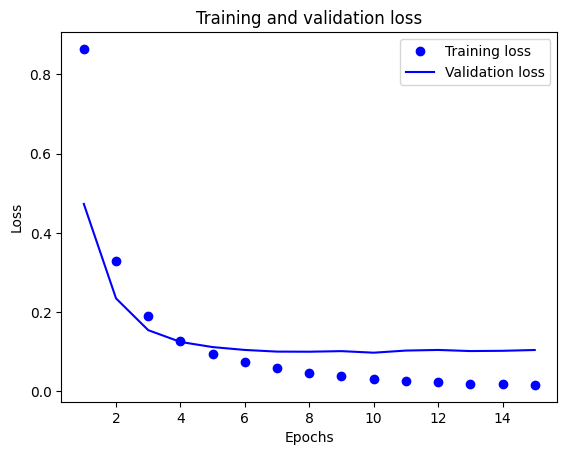

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

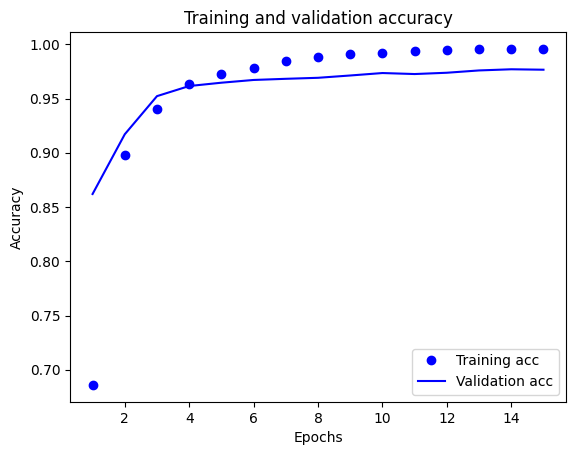

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [30]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('Softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_val_ds)
print(accuracy)

235/235 [==============================] - 1s 5ms/step - loss: 0.1046 - accuracy: 0.9766
0.9765770435333252


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [31]:
import numpy as np

In [32]:
examples = [
  "ویروس کرونا جان خیلی ها را گرفت",
  "فوتبال نوجوانان کشور با نتیجه 2 بر 0 به پایان رسید.",
  "تهران پایخت ایران است."
]

p = export_model.predict(examples)
results = np.argmax(p, axis=1)

for r in results:
  print(raw_train_ds.class_names[r])

1/1 [==============================] - 0s 136ms/step
جغرافیا و مکانها
ورزش
جغرافیا و مکانها


## Confusion matrix

In [54]:
features = raw_val_ds.map(lambda x, y: x)
labels = raw_val_ds.map(lambda x, y: y)

In [55]:
predictions = export_model.predict(features)
predicted_classes = tf.math.argmax(predictions, axis=-1)

235/235 [==============================] - 1s 4ms/step


In [56]:
# Get the actual data from the MapDataset object
labels_list = list(labels.as_numpy_iterator())

# Flatten the batched labels
labels = np.concatenate(labels_list, axis=0)

In [57]:
confusion_mtx = tf.math.confusion_matrix(labels, predicted_classes)
confusion_mtx

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[  12,  237,    5,    0,   57,   71],
       [ 221, 2645,   46,   34,  771,  719],
       [   7,   67,    2,    0,   16,   17],
       [   3,   38,    0,    0,   13,    7],
       [  81,  753,   20,    9,  236,  216],
       [  65,  730,   14,   11,  209,  182]], dtype=int32)>

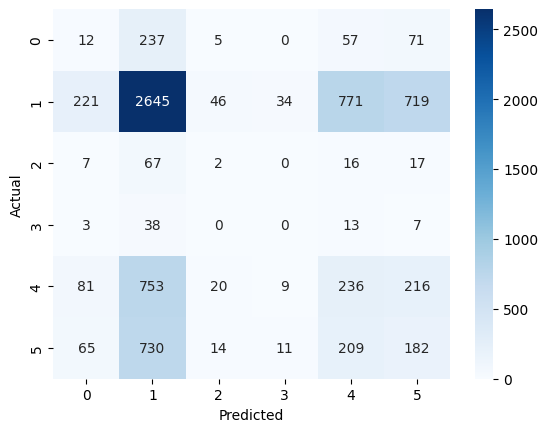

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [68]:
!pip install python-bidi

In [70]:
!pip install arabic_reshaper

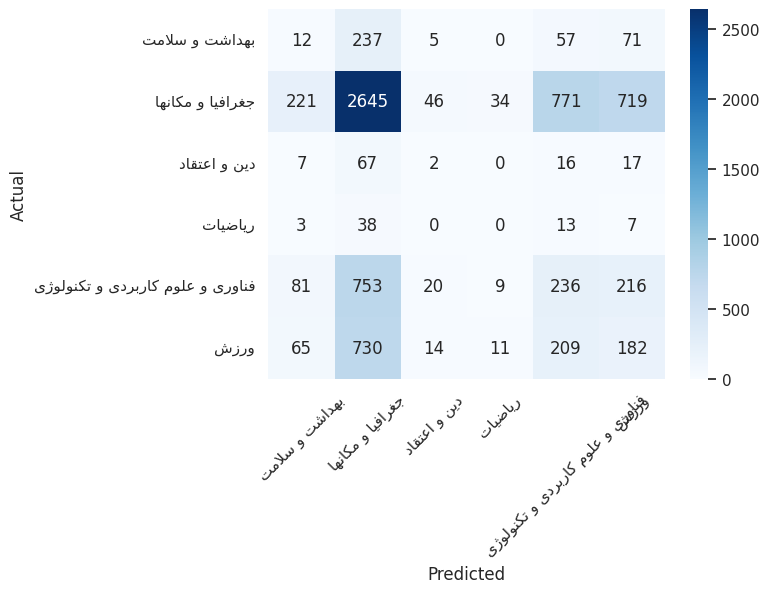

In [82]:
import arabic_reshaper
from bidi.algorithm import get_display

def convert_text(t):
    reshaped_text = arabic_reshaper.reshape(t) # seperated chars problem
    bidi_text = get_display(reshaped_text) #direction problem
    text = bidi_text.encode().decode('utf-8') #encoding problem (rectangular boxes!)
    return text

class_names = [convert_text(t) for t in raw_train_ds.class_names]

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0)

plt.show()


In [88]:
from sklearn.metrics import classification_report
report = classification_report(labels, predicted_classes)

for i in range(6):
  print("Label {} corresponds to {}".format(i, raw_train_ds.class_names[i]))
print(report)

Label 0 corresponds to بهداشت و سلامت
Label 1 corresponds to جغرافیا و مکانها
Label 2 corresponds to دین و اعتقاد
Label 3 corresponds to ریاضیات
Label 4 corresponds to فناوری و علوم کاربردی و تکنولوژی
Label 5 corresponds to ورزش
              precision    recall  f1-score   support

           0       0.03      0.03      0.03       382
           1       0.59      0.60      0.59      4436
           2       0.02      0.02      0.02       109
           3       0.00      0.00      0.00        61
           4       0.18      0.18      0.18      1315
           5       0.15      0.15      0.15      1211

    accuracy                           0.41      7514
   macro avg       0.16      0.16      0.16      7514
weighted avg       0.41      0.41      0.41      7514

